In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import seaborn as sb
%matplotlib inline

In [2]:
lags = '18'
resample_freq = '2H'

In [3]:
breath_df = pd.read_hdf('c:\Research_data\Analysis\Lagged_DS\ds_breath_data.h5')
resampled_df = pd.read_hdf('c:\Research_data\Analysis\Lagged_DS\ds_lagged_data_' + resample_freq +'.h5', 'table')
resampled_df.sort_index(inplace=True)

patient_df = pd.read_hdf('c:\Research_data\Analysis\Lagged_DS\ds_patient.h5', 'patient')
patient_df.rename(columns={'Study ID':'patient_id', 'Age':'age', 'Gender':'gender', 
                           'Hospital Discharge Date/Time':'hosp_dc_time', 'P/F Ratio':'p_to_f', 
                           'Discharge Location': 'dc_loc'}, inplace=True)
patient_df.drop(['NMB', 'Start_End_NMB'], inplace=True, axis=1)
patient_df.dc_loc = patient_df.dc_loc.astype('category')
patient_df.hosp_dc_time = pd.to_datetime(patient_df.hosp_dc_time)
patient_df.set_index('patient_id', inplace=True, drop=True)

In [4]:
patient_df.head()

,age,gender,hosp_dc_time,p_to_f,dc_loc
patient_id,,,,,
100,25,Male,2014-04-25 15:37:00,225.000000,Home
101,65,Male,2014-05-02 14:40:00,75.555556,Died
102,49,Female,2014-05-19 13:17:00,101.000000,Home
103,58,Female,2014-06-03 16:02:00,195.000000,Home
104,42,Male,2014-07-19 14:10:00,142.857143,Home


In [5]:
resampled_df.columns

Index(['NMB', 'NMB_lag12', 'NMB_lag18', 'NMB_lag24', 'NMB_lag6', 'NMB_sum',
       'breath_num', 'date_time', 'ds_freq', 'ds_lag_12', 'ds_lag_18',
       'ds_lag_24', 'ds_lag_6', 'elapse_time', 'fio2', 'fio2_diff_lag_12',
       'fio2_diff_lag_18', 'fio2_diff_lag_24', 'fio2_diff_lag_6',
       'fio2_lag_12', 'fio2_lag_18', 'fio2_lag_24', 'fio2_lag_6', 'label.ds',
       'patient_id', 'peak_paw', 'peak_paw_diff_lag_12',
       'peak_paw_diff_lag_18', 'peak_paw_diff_lag_24', 'peak_paw_diff_lag_6',
       'peak_paw_lag_12', 'peak_paw_lag_18', 'peak_paw_lag_24',
       'peak_paw_lag_6', 'peak_vol', 'peep', 'peep_diff_lag_12',
       'peep_diff_lag_18', 'peep_diff_lag_24', 'peep_diff_lag_6',
       'peep_lag_12', 'peep_lag_18', 'peep_lag_24', 'peep_lag_6', 'set_vt',
       'set_vt_diff_lag_12', 'set_vt_diff_lag_18', 'set_vt_diff_lag_24',
       'set_vt_diff_lag_6', 'set_vt_lag_12', 'set_vt_lag_18', 'set_vt_lag_24',
       'set_vt_lag_6', 'ds_lag_6_bin', 'ds_lag_12_bin', 'ds_lag_18_bin',
   

In [6]:
breath_df.head()

,_id,elapse_time,peak_vol,breath_num,fio2,peak_paw,peep,set_vt,date_time,label.ds,patient_id
patient_id,,,,,,,,,,,
100,100/2.0/2014-04-21 13:01:33/4352.0,3936,465.0,2.0,40.0,25.0,5.0,510.0,2014-04-21 13:01:33,0.0,100
100,100/3.0/2014-04-21 13:01:37/8320.0,3616,460.0,3.0,40.0,26.0,5.0,510.0,2014-04-21 13:01:37,0.0,100
100,100/6.0/2014-04-21 17:36:36/16507593.0,3616,472.5,6.0,40.0,24.0,5.0,510.0,2014-04-21 17:36:36,NaN,100
100,100/7.0/2014-04-21 17:36:40/16511241.0,1024,435.0,7.0,40.0,23.0,5.0,510.0,2014-04-21 17:36:40,NaN,100
100,100/1.0/2014-04-21 17:36:55/1856.0,3904,502.5,1.0,40.0,23.0,5.0,510.0,2014-04-21 17:36:55,0.0,100


In [7]:
breath_duration = breath_df.groupby('patient_id')
breath_duration = breath_duration['date_time'].max() - breath_duration['date_time'].min()
breath_duration[breath_duration < pd.to_timedelta('48H')]

patient_id
100   1 days 00:33:17
102   0 days 05:00:05
103   1 days 17:03:43
106   1 days 18:37:17
107   0 days 03:04:19
108   0 days 02:25:38
109   1 days 01:03:36
112   1 days 02:55:47
114   1 days 14:26:00
115   1 days 11:12:00
116   0 days 14:27:35
118   1 days 01:38:03
121   1 days 19:10:16
126   1 days 17:11:39
128   0 days 03:26:09
130   0 days 11:21:02
Name: date_time, dtype: timedelta64[ns]

In [8]:
tot_duration_df = resampled_df
grouped = tot_duration_df.groupby(['patient_id'])
tot_duration_df = grouped['date_time'].max() - grouped['date_time'].min()
tot_duration_df[tot_duration_df < pd.to_timedelta('48H')]

patient_id
107   1 days 22:00:00
128   1 days 18:00:00
Name: date_time, dtype: timedelta64[ns]

In [9]:
grouped = resampled_df.groupby(['patient_id'])
count_df = grouped[['label.ds', 'ds_lag_'+lags, 'fio2_diff_lag_'+lags, 'peep_diff_lag_'+lags]].count()
count_df

,label.ds,ds_lag_18,fio2_diff_lag_18,peep_diff_lag_18
patient_id,,,,
100,3,3,18,18
101,24,24,118,118
102,2,2,27,27
103,19,19,24,24
105,18,18,123,123
106,22,22,25,25
107,2,2,6,6
108,2,2,47,47
109,14,14,17,17


In [10]:
count_df.shape

(30, 4)

In [11]:
np.count_nonzero(count_df['ds_lag_'+lags].values)

30

In [12]:
np.count_nonzero(count_df['fio2_diff_lag_'+lags].values)

30

In [13]:
np.count_nonzero(count_df['peep_diff_lag_'+lags].values)

30

In [14]:
total = count_df.join(tot_duration_df)
total.rename(columns={'date_time':'tot_duration'}, inplace=True)
total = total.join(breath_duration)
total.rename(columns={'date_time':'breath_duration'}, inplace=True)
total['delta_duration'] = total.tot_duration -total.breath_duration
total = total.join(patient_df[['hosp_dc_time', 'dc_loc']])
total

,label.ds,ds_lag_18,fio2_diff_lag_18,peep_diff_lag_18,tot_duration,breath_duration,delta_duration,hosp_dc_time,dc_loc
patient_id,,,,,,,,,
100,3,3,18,18,2 days 22:00:00,1 days 00:33:17,1 days 21:26:43,2014-04-25 15:37:00,Home
101,24,24,118,118,11 days 06:00:00,3 days 18:21:48,7 days 11:38:12,2014-05-02 14:40:00,Died
102,2,2,27,27,3 days 16:00:00,0 days 05:00:05,3 days 10:59:55,2014-05-19 13:17:00,Home
103,19,19,24,24,3 days 10:00:00,1 days 17:03:43,1 days 16:56:17,2014-06-03 16:02:00,Home
105,18,18,123,123,11 days 20:00:00,5 days 06:46:56,6 days 13:13:04,2014-10-04 11:46:00,SNF
106,22,22,25,25,3 days 12:00:00,1 days 18:37:17,1 days 17:22:43,2014-09-21 16:54:00,Other Hospital
107,2,2,6,6,1 days 22:00:00,0 days 03:04:19,1 days 18:55:41,2014-10-04 11:14:00,Died
108,2,2,47,47,5 days 08:00:00,0 days 02:25:38,5 days 05:34:22,2014-10-11 12:49:00,Died
109,14,14,17,17,2 days 20:00:00,1 days 01:03:36,1 days 18:56:24,2014-10-13 16:24:00,Home


In [15]:
resampled_df[resampled_df.patient_id == 119.0][['fio2', 'peep', 'fio2_lag_'+lags, 'peep_lag_'+lags,'fio2_diff_lag_'+lags,
                                                'peep_diff_lag_'+lags, 'ds_freq', 'ds_lag_'+lags]]

,fio2,peep,fio2_lag_18,peep_lag_18,fio2_diff_lag_18,peep_diff_lag_18,ds_freq,ds_lag_18
date_time,,,,,,,,
2015-02-27 12:00:00,86.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27 14:00:00,80.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27 16:00:00,60.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27 18:00:00,50.000000,9.500000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27 20:00:00,50.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27 22:00:00,51.666667,8.833333,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 00:00:00,53.333333,8.666667,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 02:00:00,50.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 04:00:00,50.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
breath_df[breath_df.patient_id == 100.0]

,_id,elapse_time,peak_vol,breath_num,fio2,peak_paw,peep,set_vt,date_time,label.ds,patient_id
patient_id,,,,,,,,,,,
100,100/2.0/2014-04-21 13:01:33/4352.0,3936,465.0,2.0,40.0,25.0,5.0,510.0,2014-04-21 13:01:33,0.0,100
100,100/3.0/2014-04-21 13:01:37/8320.0,3616,460.0,3.0,40.0,26.0,5.0,510.0,2014-04-21 13:01:37,0.0,100
100,100/6.0/2014-04-21 17:36:36/16507593.0,3616,472.5,6.0,40.0,24.0,5.0,510.0,2014-04-21 17:36:36,NaN,100
100,100/7.0/2014-04-21 17:36:40/16511241.0,1024,435.0,7.0,40.0,23.0,5.0,510.0,2014-04-21 17:36:40,NaN,100
100,100/1.0/2014-04-21 17:36:55/1856.0,3904,502.5,1.0,40.0,23.0,5.0,510.0,2014-04-21 17:36:55,0.0,100
100,100/2.0/2014-04-21 17:36:59/5792.0,3616,490.0,2.0,40.0,24.0,5.0,510.0,2014-04-21 17:36:59,0.0,100
100,100/3.0/2014-04-21 17:37:02/9440.0,3648,512.5,3.0,40.0,24.0,5.0,510.0,2014-04-21 17:37:02,0.0,100
100,100/4.0/2014-04-21 17:37:06/13120.0,3776,465.0,4.0,40.0,24.0,5.0,510.0,2014-04-21 17:37:06,0.0,100
100,100/5.0/2014-04-21 17:37:10/16928.0,3744,515.0,5.0,40.0,23.0,5.0,510.0,2014-04-21 17:37:10,0.0,100


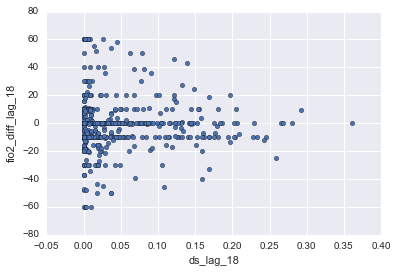

In [17]:
resampled_df.plot(x='ds_lag_'+lags, y='fio2_diff_lag_'+lags, kind='scatter')

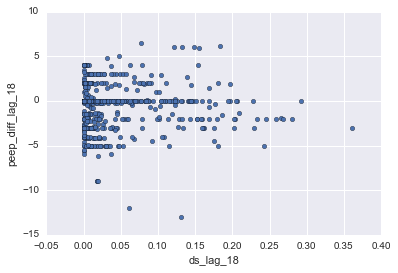

In [18]:
resampled_df.plot(x='ds_lag_'+lags, y='peep_diff_lag_'+lags, kind='scatter')

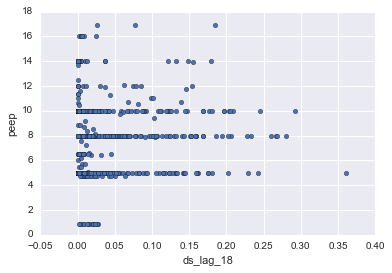

In [19]:
resampled_df.plot(x='ds_lag_'+lags, y='peep', kind='scatter')

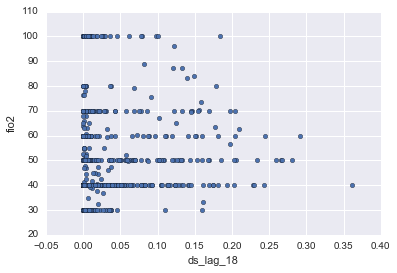

In [20]:
resampled_df.plot(x='ds_lag_'+lags, y='fio2', kind='scatter')

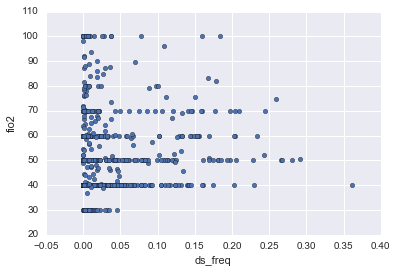

In [21]:
resampled_df.plot(x='ds_freq', y='fio2', kind='scatter')

In [22]:
grouped = resampled_df.groupby(['ds_lag_'+lags+'_bin', 'patient_id'])

In [23]:
resampled_df['ds_quant'] = pd.qcut(resampled_df['ds_freq'], [0., 0.2, 0.5,0.9, 1.])

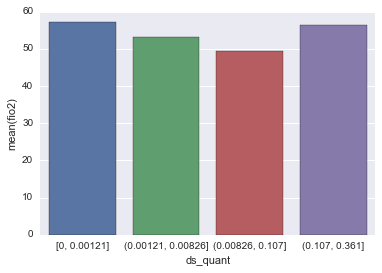

In [24]:
sb.barplot(data=resampled_df, y='fio2', x='ds_quant', ci=0.95)

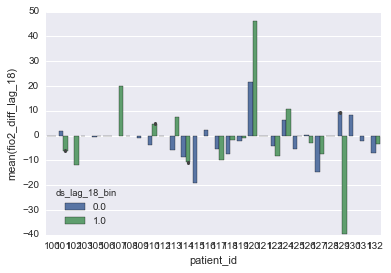

In [25]:
sb.barplot(data=resampled_df, y='fio2_diff_lag_'+lags, x='patient_id', hue='ds_lag_'+lags+'_bin', ci=0.95)

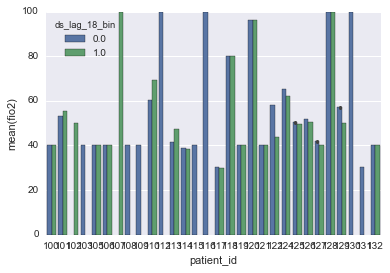

In [26]:
sb.barplot(data=resampled_df, y='fio2', x='patient_id', hue='ds_lag_'+lags+'_bin', ci=0.95)

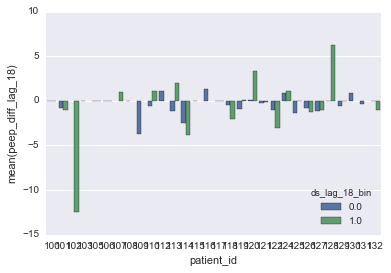

In [27]:
sb.barplot(data=resampled_df, y='peep_diff_lag_'+lags, x='patient_id', hue='ds_lag_'+lags+'_bin', ci=0.95)

In [28]:
resampled_df.groupby('ds_lag_'+lags+'_bin')[['fio2_diff_lag_'+lags, 'peep_diff_lag_'+lags, 'fio2', 'peep']].describe()

fio2_diff_lag_18  peep_diff_lag_18        fio2  \
ds_lag_18_bin                                                         
0.0           count        654.000000        654.000000  654.000000   
              mean          -1.534207         -0.593997   51.019085   
              std           16.132788          2.083603   20.146466   
              min          -60.000000         -9.000000   30.000000   
              25%          -10.000000         -1.807979   40.000000   
              50%            0.000000          0.000000   40.000000   
              75%            0.000000          0.000000   60.000000   
              max           60.000000          5.000000  100.000000   
1.0           count        148.000000        148.000000  148.000000   
              mean          -0.242687         -0.443306   54.018998   
              std           15.314525          2.693819   16.311640   
              min          -45.984332        -13.000000   30.000000   
              25%          -10.000000         -2.000000   40.000000   
              50%            0.000000          0.000000   50.000000   
              75%            0.245518          0.000000   60.000000   
              max           50.000000          6.448675  100.000000   

                           peep  
ds_lag_18_bin                    
0.0           count  654.000000  
              mean     7.496148  
              std      3.032315  
              min      0.851064  
              25%      5.000000  
              50%      8.000000  
              75%     10.000000  
              max     16.921892  
1.0           count  148.000000  
              mean     8.207531  
              std      2.573905  
              min      4.748079  
              25%      5.000000  
              50%      8.000000  
              75%     10.000000  
              max     16.921892

In [29]:
ttest_ind(resampled_df[resampled_df['ds_lag_'+lags+'_bin']==1]['fio2_diff_lag_'+lags].dropna(),
          resampled_df[resampled_df['ds_lag_'+lags+'_bin']==0]['fio2_diff_lag_'+lags].dropna())

(0.88757554064177646, 0.37503587574865427, 800.0)

In [30]:
ttest_ind(resampled_df[resampled_df['ds_lag_'+lags+'_bin']==1]['peep_diff_lag_'+lags].dropna(),
          resampled_df[resampled_df['ds_lag_'+lags+'_bin']==0]['peep_diff_lag_'+lags].dropna())

(0.74961766956584297, 0.45370538020646189, 800.0)

In [31]:
ttest_ind(resampled_df[resampled_df['ds_lag_'+lags+'_bin']==1]['fio2'].dropna(),
          resampled_df[resampled_df['ds_lag_'+lags+'_bin']==0]['fio2'].dropna())

(1.6902107038657155, 0.091377219942577234, 800.0)

In [32]:
ttest_ind(resampled_df[resampled_df['ds_lag_'+lags+'_bin']==1]['peep'].dropna(),
          resampled_df[resampled_df['ds_lag_'+lags+'_bin']==0]['peep'].dropna())

(2.6461278628711735, 0.0083018450637175351, 800.0)

# Look at Nth Window

In [33]:
first = resampled_df.dropna(subset=['ds_lag_'+lags+'_bin'], axis=0)
first = first.groupby('patient_id')

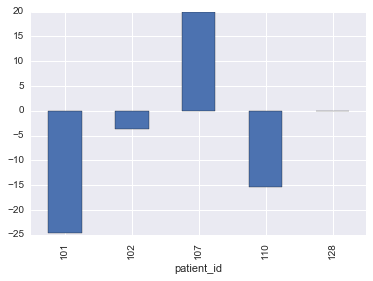

In [34]:
grouped_first = first.nth(1)
grouped_first[grouped_first['ds_lag_'+lags+'_bin']==1]['fio2_diff_lag_'+lags].plot(kind='bar')

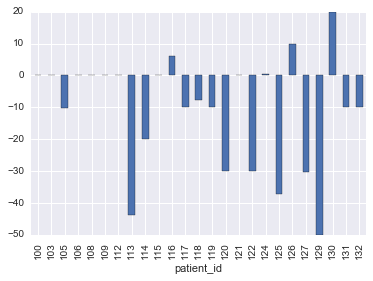

In [35]:
grouped_first[grouped_first['ds_lag_'+lags+'_bin']==0]['fio2_diff_lag_'+lags].plot(kind='bar')

In [36]:
grouped_first = grouped_first.groupby('ds_lag_'+lags+'_bin')

In [37]:
grouped_first[['fio2_diff_lag_'+lags, 'peep_diff_lag_'+lags, 'fio2', 'peep']].describe()

fio2_diff_lag_18  peep_diff_lag_18        fio2       peep
ds_lag_18_bin                                                                 
0.0           count         25.000000         25.000000   25.000000  25.000000
              mean         -10.497878         -0.969450   53.388018   7.700709
              std           17.384111          3.027913   21.531227   3.584180
              min          -50.000000         -9.000000   30.000000   0.851064
              25%          -20.000000         -3.000000   40.000000   5.000000
              50%           -7.724719          0.000000   40.000000   8.000000
              75%            0.000000          0.000000   60.000000  10.000000
              max           20.000000          4.780488  100.000000  16.000000
1.0           count          5.000000          5.000000    5.000000   5.000000
              mean          -4.773543         -1.510265   72.000000   9.784378
              std           16.905516          7.144594   25.884358   4.518853
              min          -24.651361        -13.000000   50.000000   5.000000
              25%          -15.426983         -2.000000   50.000000   8.000000
              50%           -3.727811          0.000000   60.000000   8.000000
              75%            0.000000          1.000000  100.000000  11.000000
              max           19.938440          6.448675  100.000000  16.921892

# Check CrossCorrelation

In [38]:
import pandas.tools.plotting as plt
import scipy.signal as sp
from sklearn.preprocessing import scale

In [39]:
patients = resampled_df['patient_id'].unique().tolist()

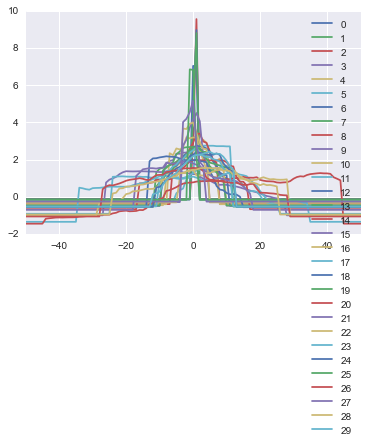

In [40]:
corr_df = pd.DataFrame(index=np.arange(-50,51,1))

for pts in patients:
    fio2 = resampled_df[resampled_df.patient_id == pts].dropna(subset=['peep', 'ds_freq'], how='any')['peep'].values
    dsfreq = resampled_df[resampled_df.patient_id == pts].dropna(subset=['peep', 'ds_freq'], how='any')['ds_freq'].values
    corr = sp.correlate(dsfreq, fio2, mode='same')

    corr_df[pts] = np.pad(corr, (int(np.ceil((101-corr.shape[0])/2)), int(np.floor((101-corr.shape[0])/2))), mode='constant')
    

corr_df= pd.DataFrame(scale(corr_df.values), index=np.arange(-50,51,1))
corr_df.plot()                        

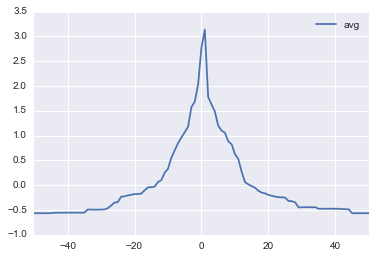

In [41]:
corr_df['avg'] = corr_df.mean(axis=1)
corr_df.plot(y='avg')

# Expanding Window Analysis

In [71]:
expanding_df = resampled_df[['ds_freq', 'NMB', 'NMB_sum',
       'breath_num', 'elapse_time', 'fio2', 'label.ds',
       'patient_id', 'peak_paw', 'peak_vol', 'peep', 'set_vt']]
expanding_df.head()

,ds_freq,NMB,NMB_sum,breath_num,elapse_time,fio2,label.ds,patient_id,peak_paw,peak_vol,peep,set_vt
date_time,,,,,,,,,,,,
2014-04-21 02:00:00,NaN,0.0,NaN,0.0,NaN,40.0,NaN,100,NaN,NaN,5.0,510.0
2014-04-21 04:00:00,NaN,0.0,NaN,0.0,NaN,40.0,NaN,100,NaN,NaN,5.0,510.0
2014-04-21 06:00:00,NaN,0.0,NaN,0.0,NaN,40.0,NaN,100,NaN,NaN,5.0,510.0
2014-04-21 08:00:00,NaN,0.0,NaN,0.0,NaN,40.0,NaN,100,NaN,NaN,5.0,510.0
2014-04-21 10:00:00,NaN,0.0,NaN,0.0,NaN,40.0,NaN,100,NaN,NaN,5.0,510.0


In [99]:
grouped = expanding_df.groupby('patient_id')
test_sum = grouped[['NMB', 'NMB_sum', 'breath_num', 'label.ds']].transform(
        lambda x: x.expanding().mean())

test_mean = grouped[['ds_freq', 'elapse_time', 'fio2', 'peak_paw', 'peak_vol', 'peep', 'set_vt', 'patient_id']].transform(
        lambda x: pd.DataFrame.rolling(x, window=4).max())

test_3 = test_sum.join(test_mean)            
            
#'ds_freq': np.mean, 'NMB':sum, 'NMB_sum':sum,
#'breath_num':sum, 'elapse_time':np.mean, 'fio2':max, 'label.ds':sum,
#'patient_id':max, 'peak_paw':np.mean, 'peak_vol':np.mean, 'peep':np.mean, 'set_vt':np.mean}))


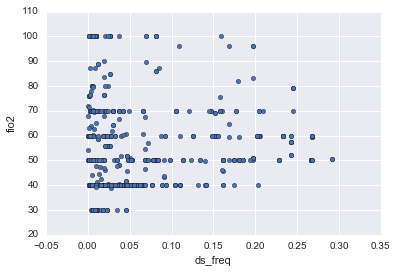

In [111]:
test_3.plot(x='ds_freq', y='fio2', kind='scatter')

In [115]:
test_3['bin'] = pd.cut(test_3['ds_freq'], [0, 0.05, 1], labels=[0,1])

In [116]:
test_3.groupby('bin').describe()

NMB     NMB_sum   breath_num     ds_freq  elapse_time  \
bin                                                                       
0   count  479.000000  367.000000   479.000000  479.000000   479.000000   
    mean     0.182039    3.236093  1602.423171    0.016184  2837.111947   
    std      0.325482    5.944509   805.077681    0.012954   801.763668   
    min      0.000000    0.000000     0.000000    0.000421  1778.526316   
    25%      0.000000    0.000000   923.210692    0.005646  2107.896212   
    50%      0.000000    0.000000  1656.833333    0.011918  2697.565880   
    75%      0.167840    3.219697  2288.490809    0.024527  3279.705354   
    max      1.000000   18.000000  3135.000000    0.049531  6374.361446   
1   count  241.000000  165.000000   241.000000  241.000000   241.000000   
    mean     0.060222    1.551053  1387.820834    0.140247  3269.866810   
    std      0.149049    3.195894   681.316918    0.069060   922.527327   
    min      0.000000    0.000000    11.555556    0.050416  1749.995594   
    25%      0.000000    0.000000   963.806897    0.077060  2684.967400   
    50%      0.000000    0.000000  1467.166667    0.139337  3162.000000   
    75%      0.000000    0.000000  1899.000000    0.196765  3663.677519   
    max      0.647059   13.580645  2971.555556    0.291667  6260.848619   

                 fio2    label.ds  patient_id    peak_paw    peak_vol  \
bin                                                                     
0   count  479.000000  473.000000  479.000000  479.000000  479.000000   
    mean    56.335079   44.605033  119.615866   26.143873  436.498165   
    std     21.619919   48.207671    7.235044    6.490849  103.753265   
    min     30.000000    0.400000  103.000000   11.612375  242.577299   
    25%     40.000000   10.928571  115.000000   22.041545  393.535630   
    50%     50.000000   31.235294  120.000000   26.948141  424.753401   
    75%     70.000000   60.777778  125.000000   30.905378  453.728266   
    max    100.000000  220.594595  131.000000   41.399843  930.680628   
1   count  241.000000  241.000000  241.000000  241.000000  241.000000   
    mean    54.870107  112.440346  118.481328   21.737248  512.487271   
    std     14.675666   82.562612    7.994312    5.064892  138.332772   
    min     40.000000    4.047619  101.000000   11.788261  337.164565   
    25%     40.000000   57.000000  113.000000   18.444577  417.440642   
    50%     50.000000   91.416667  120.000000   21.243514  471.638225   
    75%     60.000000  162.437500  126.000000   24.405635  550.999230   
    max    100.000000  363.571429  132.000000   36.149108  895.216993   

                 peep      set_vt  
bin                                
0   count  479.000000  474.000000  
    mean     8.168808  431.808794  
    std      3.133593   71.325896  
    min      5.000000  270.000000  
    25%      5.000000  400.000000  
    50%      8.000000  440.000000  
    75%     10.000000  480.000000  
    max     16.000000  630.000000  
1   count  241.000000  241.000000  
    mean     8.715524  432.430322  
    std      2.320171   67.322402  
    min      5.000000  310.000000  
    25%      8.000000  400.000000  
    50%     10.000000  420.000000  
    75%     10.000000  470.000000  
    max     16.000000  592.500000